In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc,roc_curve,roc_auc_score

import tensorflow as tf
print("Tensorflow version:", tf.__version__)

!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

import tensorflow.keras as keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image

!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

2021-09-29 01:06:59.371432: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Tensorflow version: 2.4.1
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-razsbzk6
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-razsbzk6
  Resolved https://github.com/tensorflow/docs to commit b5803ba0b65ad008da7dfb3932cf3cdbdfa917b3
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=157709 sha256=8836c1362a53fd65ee7f71760fd05b41feed0706f044810db2e8ab22b02811e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-6raqvgpj/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


## Exploratory Data Analysis

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename));

/kaggle/input/monalisa/1.jpg
/kaggle/input/monalisa/3.jpg
/kaggle/input/monalisa/mona.jpg
/kaggle/input/monalisa/2.jpg
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv


In [3]:
#define path to the data directory
base_dir = '/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/'

In [4]:
os.listdir(base_dir)

['icml_face_data.csv',
 'fer2013.tar.gz',
 'example_submission.csv',
 'train.csv',
 'test.csv']

In [5]:
#read the entire dataset
df = pd.read_csv(base_dir+'icml_face_data.csv')
df.columns = ['emotion', 'Usage', 'pixels']
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   Usage    35887 non-null  object
 2   pixels   35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [7]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [8]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [9]:
#read train data
train = pd.read_csv(base_dir+'train.csv')
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [10]:
#read test data
test = pd.read_csv(base_dir+'test.csv')
test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [11]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

[Text(0, 0, 'Angry'),
 Text(1, 0, 'Disgust'),
 Text(2, 0, 'Fear'),
 Text(3, 0, 'Happy'),
 Text(4, 0, 'Sad'),
 Text(5, 0, 'Surprise'),
 Text(6, 0, 'Neutral')]

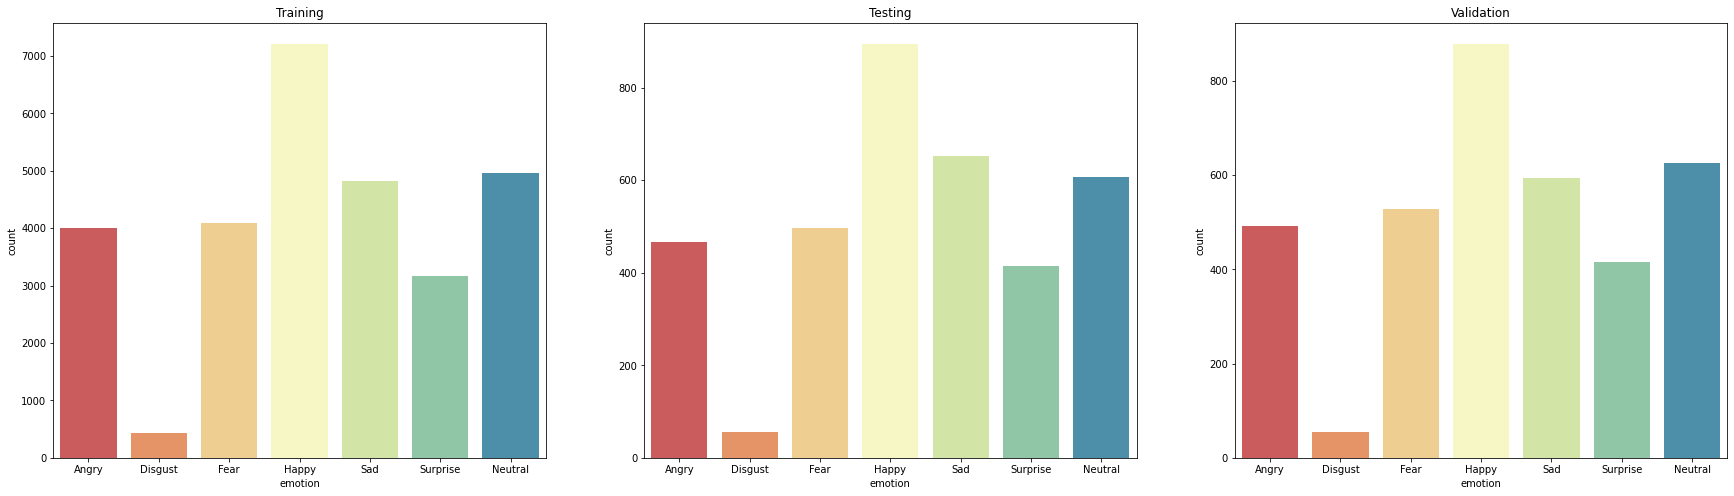

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30,8))

sns.countplot(data = df[df['Usage']=='Training'], x='emotion', ax=ax1, palette='Spectral').set_title('Training')
ax1.set_xticklabels(emotions.values())

sns.countplot(data = df[df['Usage']=='PublicTest'], x='emotion', ax=ax2, palette='Spectral').set_title('Testing')
ax2.set_xticklabels(emotions.values())

sns.countplot(data = df[df['Usage']=='PrivateTest'], x='emotion', ax=ax3, palette='Spectral').set_title('Validation')
ax3.set_xticklabels(emotions.values())

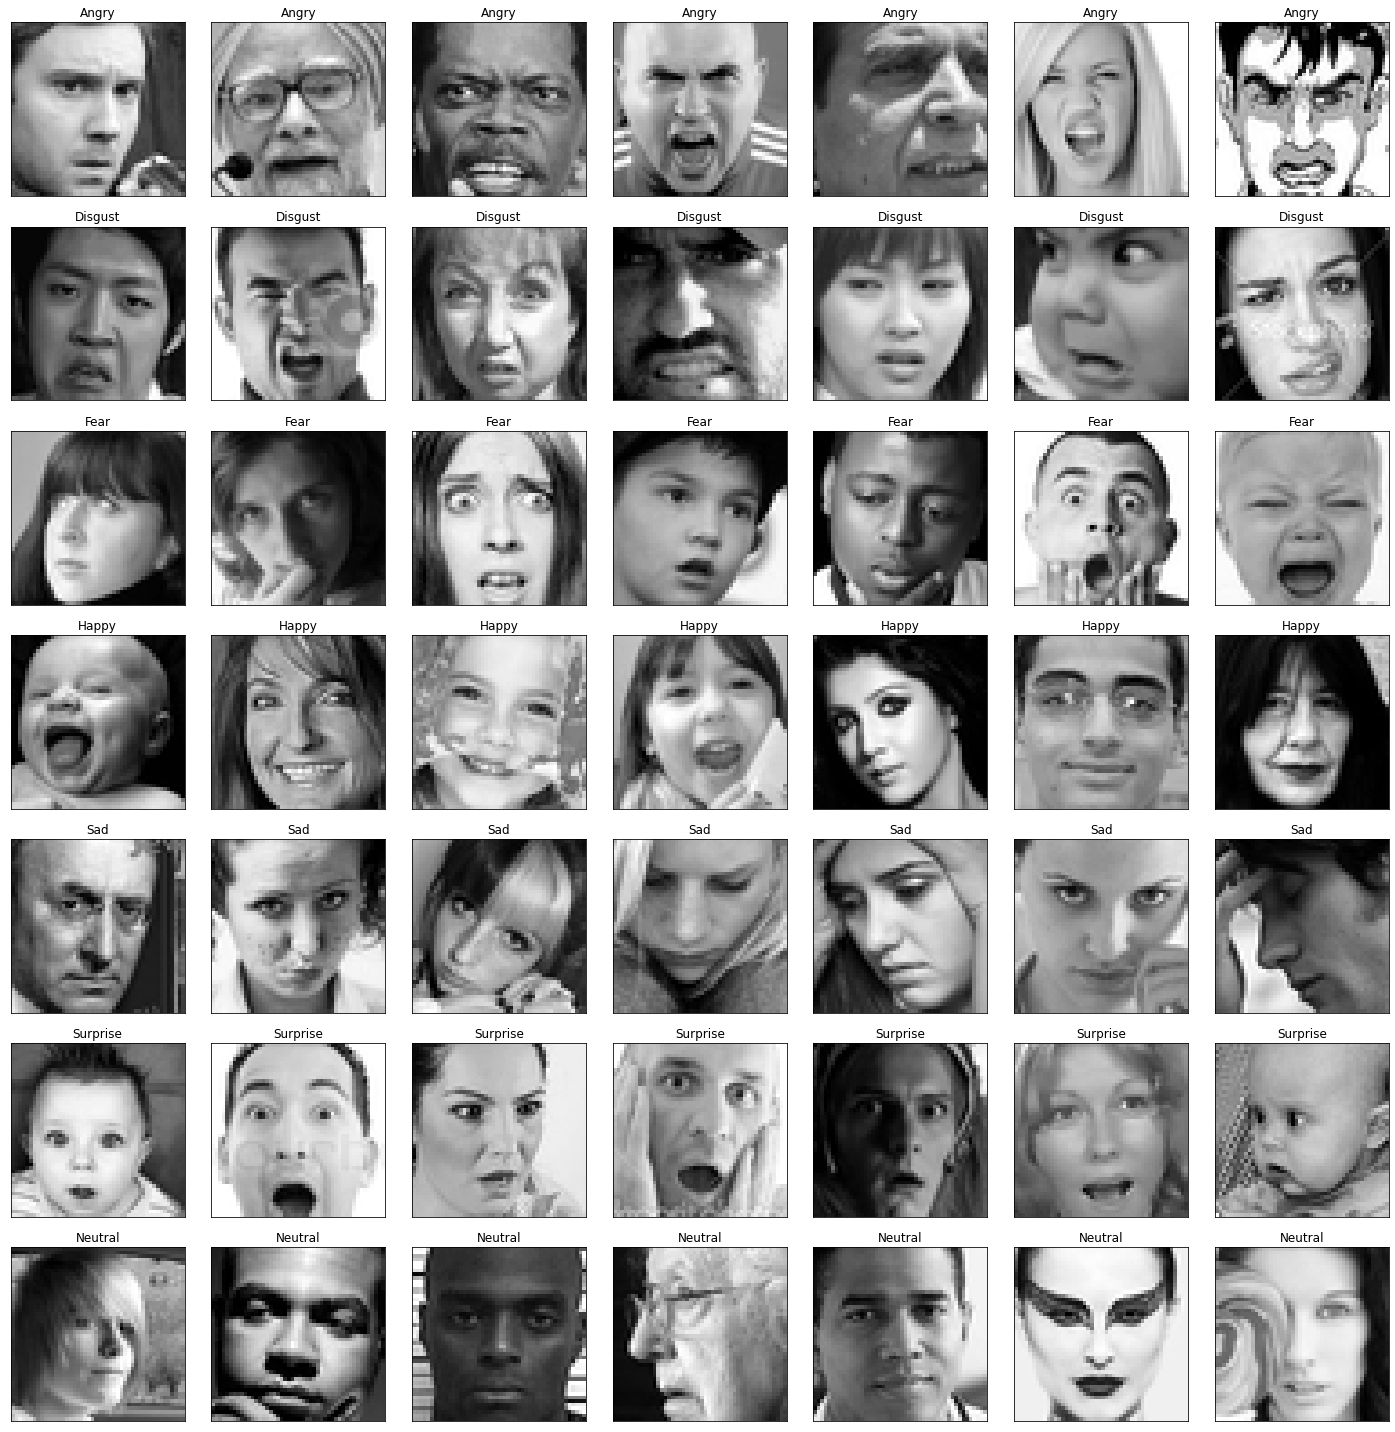

In [13]:
fig = plt.figure(1, (20, 20))

k = 0
for label in sorted(df['emotion'].unique()):
    for j in range(7):
        px = df[df['emotion']==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        plt.tight_layout()

## Prepare Train & Test Set Inputs
### Train Set

In [14]:
train_data = df[df['Usage']=='Training']
train_data.drop(columns='Usage', inplace=True)
train_data.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [15]:
train_data.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 672.9+ KB


In [17]:
train_data['pixels'][0]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [18]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

In [19]:
X_train, y_train = prepare_data(train_data)
print(X_train.shape, y_train.shape)

(28709, 48, 48, 1) (28709,)


In [20]:
X_train

array([[[[0.2745098 ],
         [0.31372549],
         [0.32156863],
         ...,
         [0.20392157],
         [0.16862745],
         [0.16078431]],

        [[0.25490196],
         [0.23921569],
         [0.22745098],
         ...,
         [0.21960784],
         [0.20392157],
         [0.17254902]],

        [[0.19607843],
         [0.16862745],
         [0.21176471],
         ...,
         [0.19215686],
         [0.21960784],
         [0.18431373]],

        ...,

        [[0.35686275],
         [0.25490196],
         [0.16470588],
         ...,
         [0.28235294],
         [0.21960784],
         [0.16862745]],

        [[0.30196078],
         [0.32156863],
         [0.30980392],
         ...,
         [0.41176471],
         [0.2745098 ],
         [0.18039216]],

        [[0.30196078],
         [0.28235294],
         [0.32941176],
         ...,
         [0.41568627],
         [0.42745098],
         [0.32156863]]],


       [[[0.59215686],
         [0.58823529],
         [0.57

In [21]:
y_train

array([0, 0, 2, ..., 4, 0, 4])

### Test Set

In [22]:
test_data = df[df['Usage']!='Training']
test_data.drop(columns='Usage', inplace=True)
test_data.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,emotion,pixels
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [23]:
X_test, y_test = prepare_data(test_data)
print(X_test.shape, y_test.shape)

(7178, 48, 48, 1) (7178,)


In [24]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)

print('y_train', y_train.shape)
print('y_test', y_test.shape)

X_train (28709, 48, 48, 1)
X_test (7178, 48, 48, 1)
y_train (28709,)
y_test (7178,)


### Train Test Split

In [25]:
#train val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  shuffle=True, 
                                                  stratify=y_train,
                                                  test_size=0.2, 
                                                  random_state=121)

### Prepare Labels

In [26]:
#encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = keras.utils.to_categorical(y_train)

In [27]:
#ecode labels
y_test = le.transform(y_test)
y_test = keras.utils.to_categorical(y_test)

In [28]:
#ecode labels
y_val = le.transform(y_val)
y_val = keras.utils.to_categorical(y_val)

In [29]:
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('y_val', y_val.shape)

y_train (22967, 7)
y_test (7178, 7)
y_val (5742, 7)


In [30]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

## Data Loader and Data Augmentation

In [32]:
img_size = 48
batch_size = 32

#use Image Data Generator to perform this task
#train set
datagen = ImageDataGenerator(rotation_range=25, 
                             width_shift_range=0.1,
                             height_shift_range=0.1, 
                             shear_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True)

datagen.fit(X_train)
datagen.fit(X_val)

## Build Model

In [33]:
model = Sequential()

#1st conv
model.add(Conv2D(128, (3,3), padding='same', input_shape=(48,48,1))) #1 is for grayscale
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2nd conv
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3rd conv
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th conv
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

2021-09-29 01:08:07.913256: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-29 01:08:07.916825: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-29 01:08:07.959034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-29 01:08:07.959695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-29 01:08:07.959785: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-29 01:08:07.990983: I tensorflow/stream_executor/platform/def

In [34]:
#compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 128)       1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

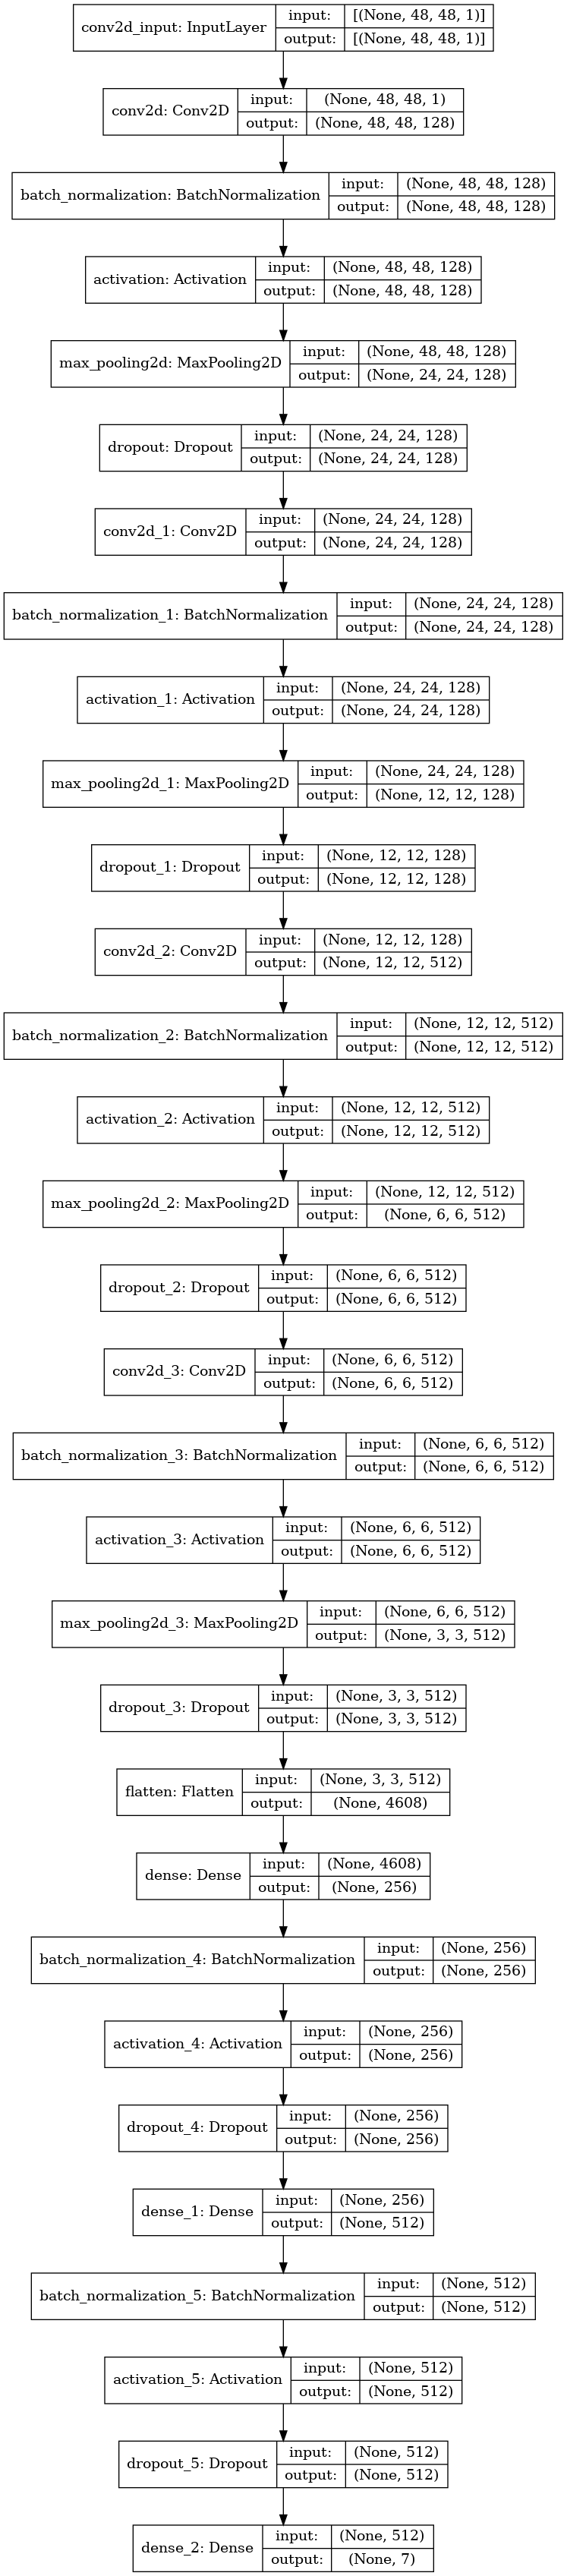

In [36]:
from tensorflow.keras.utils import plot_model

#plot
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

## Train Model

In [37]:
epochs = 100

#checkpoint to save best weights
checkpoint = ModelCheckpoint('model_weights.h5',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max')

#reduce learning rate if plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.00001,
                              mode='min')

#stop training if accuracy does not improve
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='max')

#define callbacks
callbacks = [tfdocs.modeling.EpochDots(), 
             earlystop, 
             checkpoint, 
             reduce_lr]

In [38]:
%%time

#(datagen.flow(X_train, y_train, batch_size=batch_size)
 
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    verbose=0)

2021-09-29 01:08:12.318037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-29 01:08:12.330621: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000185000 Hz
2021-09-29 01:08:13.517839: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-29 01:08:14.455851: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-29 01:08:14.488942: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8



Epoch: 0, accuracy:0.1588,  loss:2.3420,  val_accuracy:0.2227,  val_loss:2.0209,  
....................................................................................................CPU times: user 9min 7s, sys: 1min 1s, total: 10min 9s
Wall time: 15min 6s


## Evaluate Model 

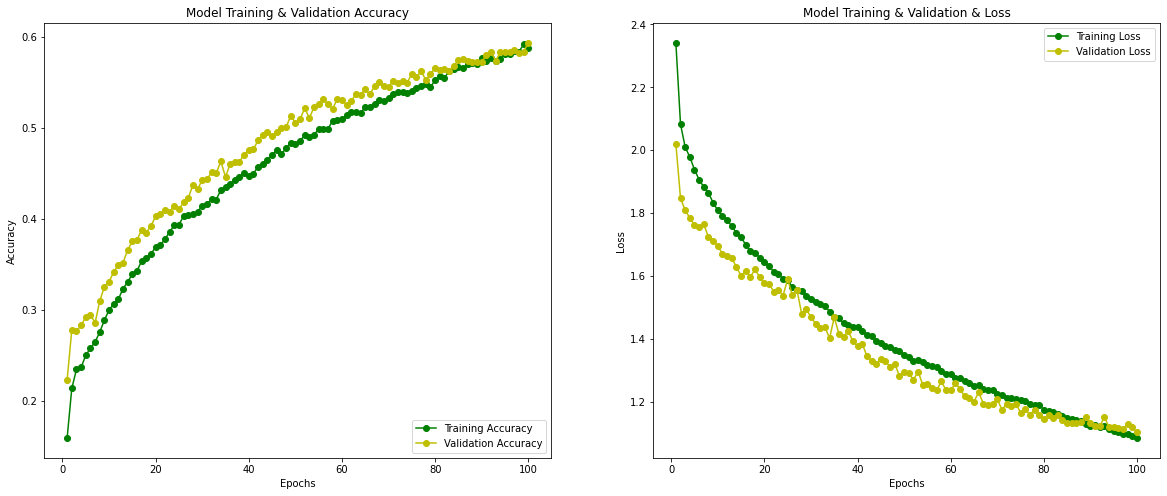

In [39]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [40]:
print('Train accuracy & loss:', model.evaluate(X_train, y_train))
print('\n')
print('Test accuracy & loss:', model.evaluate(X_test, y_test))

718/718 [==============================] - 4s 5ms/step - loss: 0.8829 - accuracy: 0.6678
Train accuracy & loss: [0.8829430937767029, 0.6677842140197754]


225/225 [==============================] - 1s 5ms/step - loss: 1.1085 - accuracy: 0.5834
Test accuracy & loss: [1.108544111251831, 0.5834494233131409]


In [41]:
#make prediction
yhat_test = np.argmax(model.predict(X_test), axis=1)
yhat_test

array([0, 3, 0, ..., 6, 4, 4])

In [42]:
y_test = np.argmax(y_test, axis=1)
y_test

array([0, 1, 4, ..., 0, 3, 2])

[[ 458   17   37   56  214   39  137]
 [  22   55    2    5   13    4   10]
 [ 115   18  170   45  349  176  151]
 [  56    7   17 1373  141   50  130]
 [ 106    7   55   58  737   31  253]
 [  30    1   27   39   35  657   42]
 [  84    2   23   68  296   22  738]]


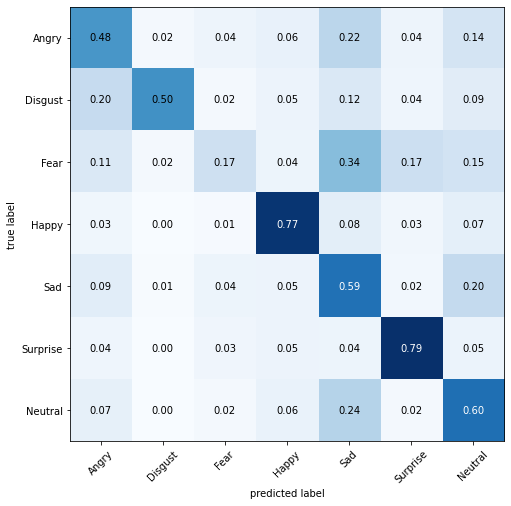

In [43]:
from mlxtend.plotting import plot_confusion_matrix

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

In [44]:
#get classification report
print(classification_report(y_test, yhat_test, target_names=emotions.values()))

              precision    recall  f1-score   support

       Angry       0.53      0.48      0.50       958
     Disgust       0.51      0.50      0.50       111
        Fear       0.51      0.17      0.25      1024
       Happy       0.84      0.77      0.80      1774
         Sad       0.41      0.59      0.49      1247
    Surprise       0.67      0.79      0.73       831
     Neutral       0.51      0.60      0.55      1233

    accuracy                           0.58      7178
   macro avg       0.57      0.56      0.55      7178
weighted avg       0.59      0.58      0.57      7178



In [45]:
model_json = model.to_json()
with open('model.json','w') as json_file:
    json_file.write(model_json)
    
model.save('final_model.h5')

## Make Prediction

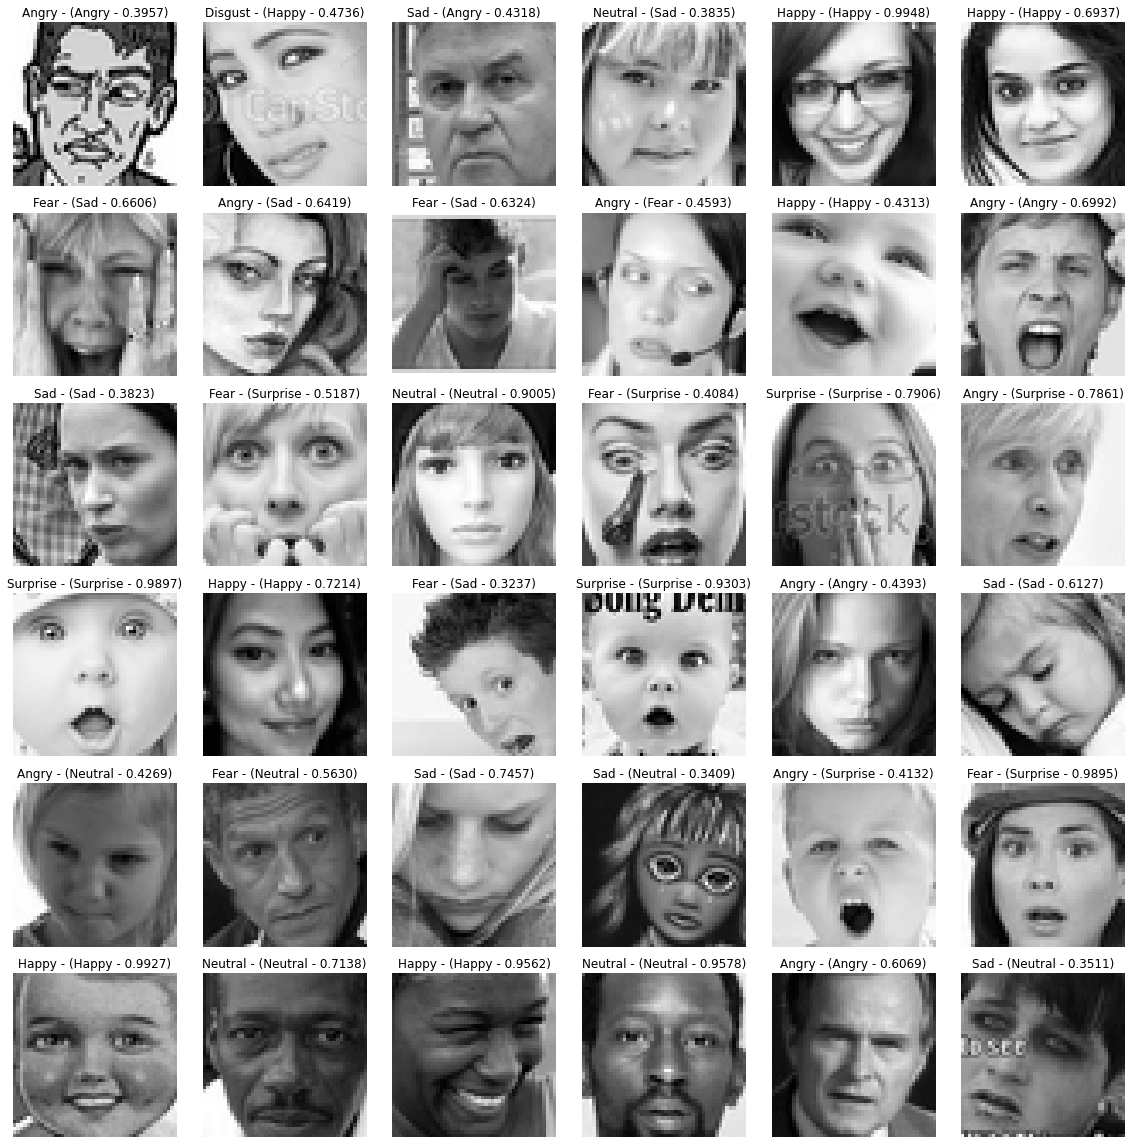

In [46]:
plt.figure(figsize=[16,16])

for i in range(36):
    img = X_test[i,:,:,0]
    p_dist = model.predict(img.reshape(1, 48, 48, 1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    plt.subplot(6, 6, i+1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'{emotions[y_test[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Grad-CAM

In [47]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )
           
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

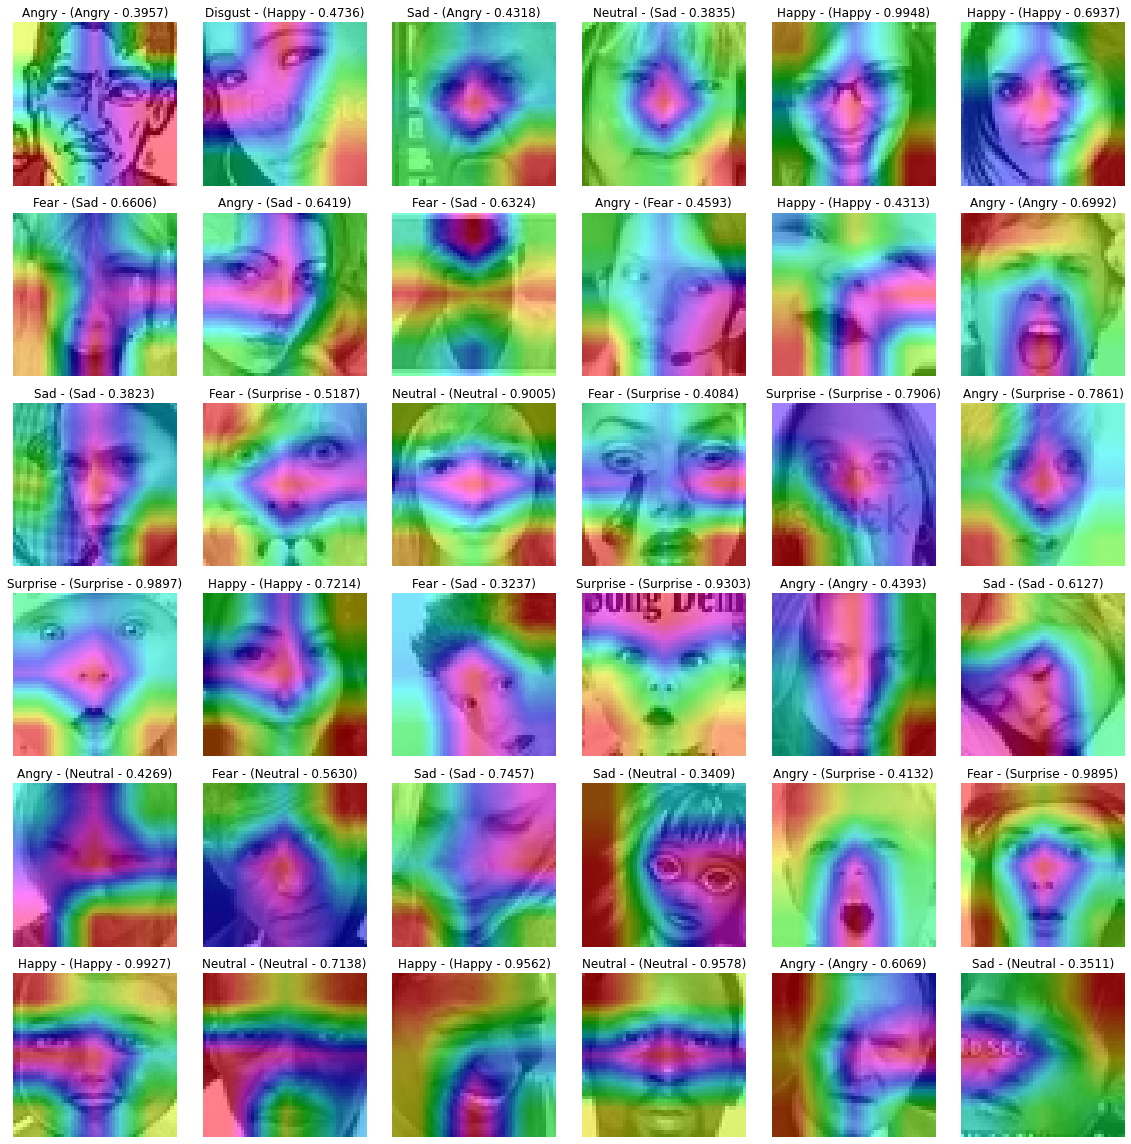

In [48]:
plt.figure(figsize=[16,16])
for i in range(36):
    img = X_test[i,:,:,0]
    p_dist = model.predict(img.reshape(1, 48, 48, 1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    cam = GradCAM(model, k)
    heatmap = cam.compute_heatmap(img.reshape(1, 48, 48, 1))

    plt.subplot(6, 6, i+1)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='hsv')
    plt.title(f'{emotions[y_test[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

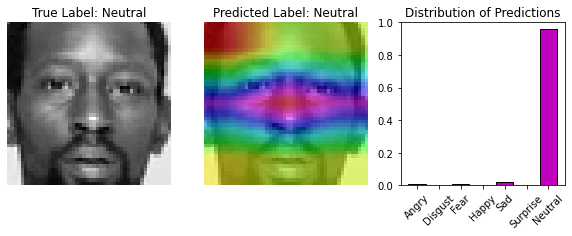

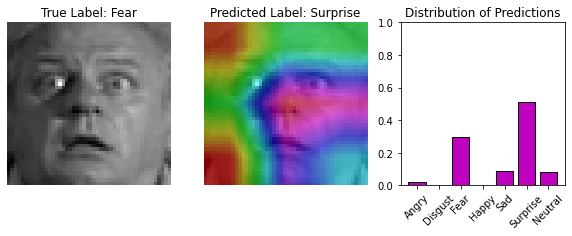

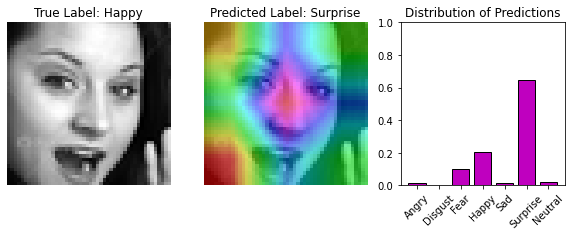

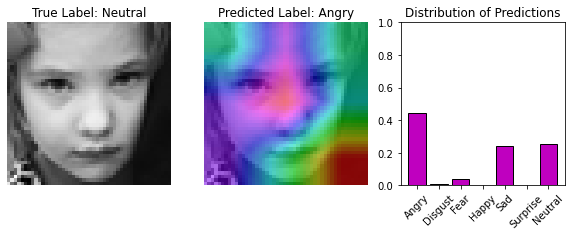

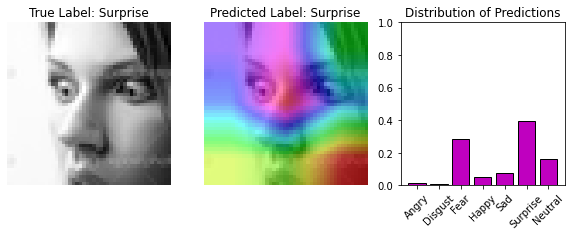

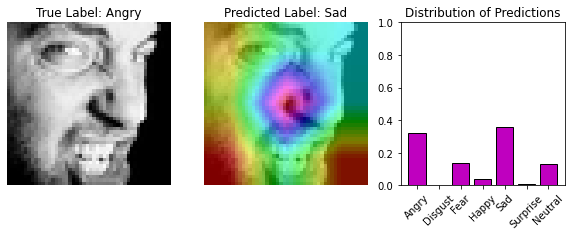

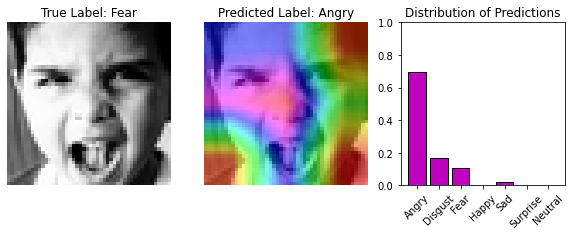

In [49]:
test_prob = model.predict(X_test)
test_pred = np.argmax(test_prob, axis=1)

sel_imgs = [33, 1000, 88, 777, 108, 111, 7000]

for n in sel_imgs:
    img = X_test[n,:,:,0]
    
    plt.figure(figsize=[10,3])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'True Label: {emotions[y_test[n]]}')
    plt.axis('off')
    
    cam = GradCAM(model, test_pred[n])
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))
    
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='hsv')
    plt.title(f'Predicted Label: {emotions[test_pred[n]]}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.bar(emotions.values(), test_prob[n, :], color='m', edgecolor='k')
    plt.xticks(rotation=45)
    plt.ylim([0,1])
    plt.title('Distribution of Predictions')
    plt.show()

## Represent Model as JSON String

In [50]:
model_json = model.to_json()

with open('model.json', 'w') as json_file:
    json_file.write(model_json)